# Import Packages

In [2]:
!pip3 install numpy
!pip3 install pandas
!pip3 install geopandas
!pip3 install regex
!pip3 install unidecode
!pip3 install nltk
!pip3 install scikit-learn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install wordcloud
!pip3 install folium
!pip3 install branca


In [3]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\selam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\selam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Convert CSV to information fo ML Model


In [4]:
import pandas as pd
df = pd.read_csv("HazardInsurance.csv")
dataset = df[["ocr_doc_page_num", "ll_doc_name_reformatted", "ll_doc_start_page", "ll_doc_stop_page","ocr_text" ]]
dataset.head()

,ocr_doc_page_num,ll_doc_name_reformatted,ll_doc_start_page,ll_doc_stop_page,ocr_text
0,1,Hazard Insurance,539,542,"['07/19/21 16:36:59 800-776-4737', 'Veterans U..."
1,2,Hazard Insurance,539,542,"['07/19/21 16:37:33 800-776-4737', 'Veterans U..."
2,3,Hazard Insurance,539,542,"['07/19/21 16:38:06 800-776-4737', 'Veterans U..."
3,1,Hazard Insurance,212,222,"['Renewal House & Home Policy Declarations', '..."
4,2,Hazard Insurance,212,222,"['Renewal House & Home Policy Declarations', '..."


# Corpus Loading:
we'll extract the ocr text column into a list of texts for our corpus.

In [5]:
corpus = dataset['ocr_text'].tolist()

# Corpus Processing
## 1. Stop Words and Stemming
We will do a data engineering routine with our anthems dataset so later we can make a good statistical model. In order to do so, we'll remove all words that don't contribute to the semantic meaning of the text (words that are not within the english alphabet) and keep all of the remaining words in the simplest format possible, so we can apply a function that gives weights to each word without generating any bias or outliers. To do that there are many techniques to clean up our corpus, among them we will remove the most common words (stop words) and apply stemming, a technique that reduces a word to it's root.

The methods that apply stemming and stop words removal are listed bellow. We will also define a method that removes any words with less than 2 letters or more than 21 letters to clean our corpus even more.

In [6]:
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

## 2. The main corpus processing function.
A section back, at the exploration of our dataset, we noticed some words containg weird characters that should be removed. By using RegEx our main processing function will remove unknown ASCII symbols, especial chars, numbers, e-mails, URLs, etc (It's a bit of a overkill, I know). It also uses the auxiliary funcitions defined above.

In [7]:
def processCorpus(corpus, language):
    stopwords = nltk.corpus.stopwords.words(language)
    common_words = ['Policy', 'policy']

    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase

        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, common_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [8]:
language = 'english'
corpus = processCorpus(corpus, language)

In [9]:
vectorizer = TfidfVectorizer(min_df = 0.2)
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))

37797 rows


In [10]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,37787,37788,37789,37790,37791,37792,37793,37794,37795,37796
cost,0.576360,0.198787,0.355638,0.000000,0.069422,0.000000,0.000000,0.000000,0.464309,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.245007,0.0,0.072770,0.000000,0.000000,0.000000
including,0.373210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035371,0.000000,...,0.000000,0.000000,0.00000,0.071113,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
number,0.325570,0.000000,0.000000,0.054132,0.104572,0.052784,0.049075,0.158678,0.020571,0.039158,...,0.182987,0.116537,0.21233,0.082714,0.123021,0.0,0.054808,0.277238,0.062419,0.145167
total,0.312253,0.000000,0.000000,0.389381,0.000000,0.000000,0.000000,0.000000,0.029594,0.000000,...,0.263253,0.000000,0.00000,0.059498,0.088491,0.0,0.078849,0.000000,0.000000,0.104422
construction,0.192202,0.000000,0.000000,0.000000,0.092602,0.093483,0.000000,0.000000,0.072864,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.163669,0.000000,0.000000


# K-Means
Function that runs the K-Means algorithm max_k times and returns a dictionary of each k result

In [16]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               #, n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

## Silhouette Score
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [17]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels, sample_size=50000) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [18]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
# silhouette(kmeans_results, final_df, plot=True)

c:\Users\selam\IDP\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
c:\Users\selam\IDP\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
c:\Users\selam\IDP\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
c:\Users\selam\IDP\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
c:\Users\selam\IDP\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
c:\Users\selam\IDP\.venv\lib\site-packages\sklearn

# Cluster Analysis
Now we can choose the best number of K and take a deeper look at each cluster. Looking at the plots above, we have some clues that when K = 5 is when the clusters are best defined. So first we will use a simple histogram to look at the most dominant words in each cluster:

In [19]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

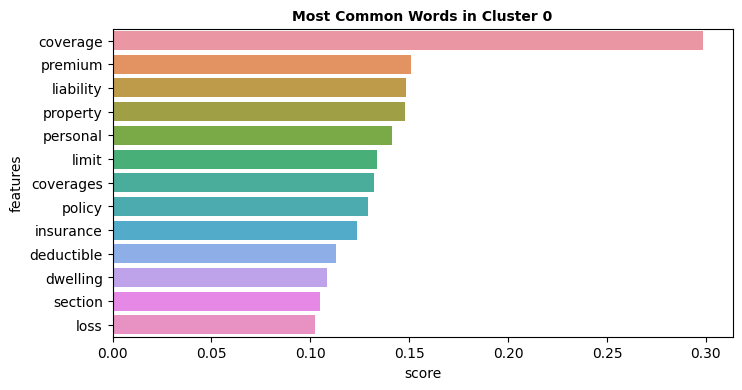

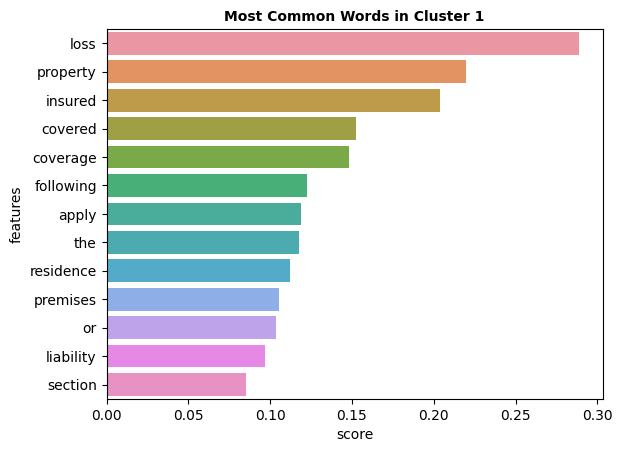

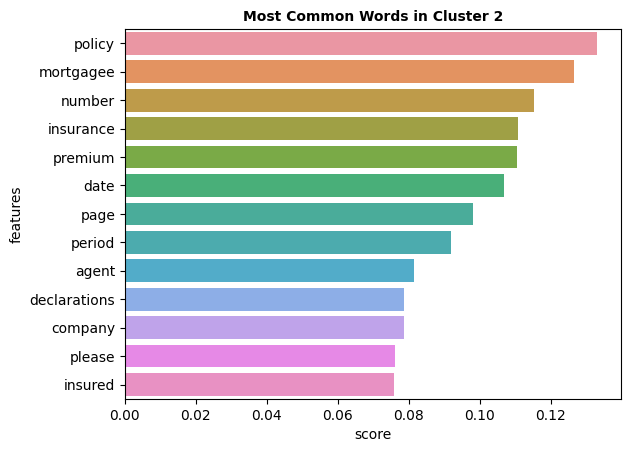

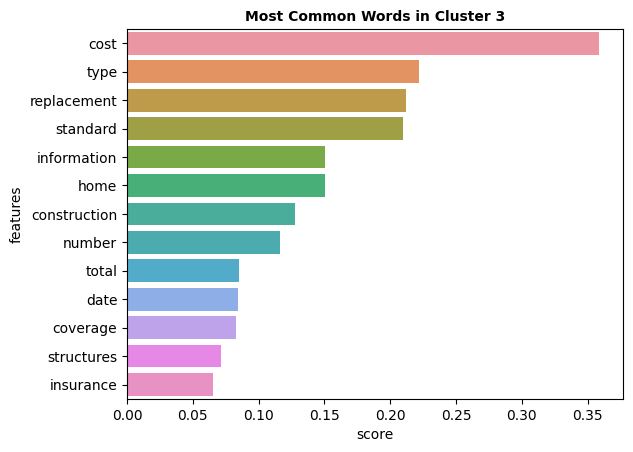

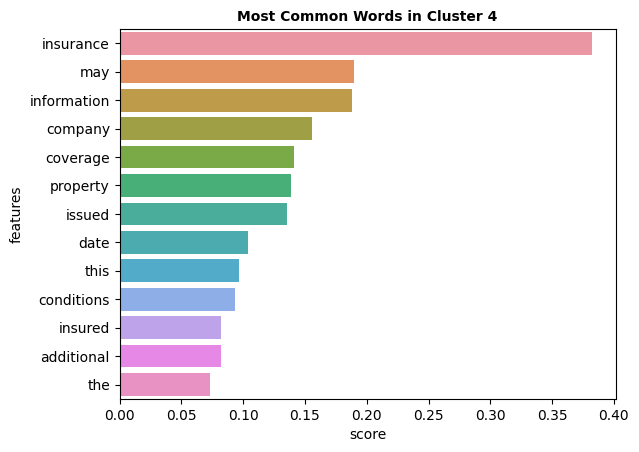

In [15]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [21]:
corpus[:100]

["'veterans united 'page 'homeowner reconstruction cost notification 'general information 'provided 'american strategic insurance 'prepared 'unknownuser/msb unknownuser 'estimate date 'policy number 'homeowner name 'property address somerville cir 'vacaville 'reconstruction cost estimate details 'coverage 'labor materials supplies 'demolition debris removal 'overhead profit 'permits architects plans including general conditions 'total estimated reconstruction cost including 'cost data 'debris removal 'building description 'main home 'number families 'site access 'flat area/easy access 'roads 'year built 'number stories 'finished living area square feet 'total living area square feet 'construction type 'standard 'slab grade 'concrete 'wall height feet",
 "'veterans united 'page 'building description continued 'perimeter 'rectangular slightly 'irregular 'please note home garage heating and/or air conditioning system displayed report 'not included reconstruction cost calculation unless ex

In [43]:
corpus[:100]

['veteran unit page homeown reconstruct cost notif general inform provid american strateg insur prepar unknownuser/msb unknownus estim date polici number homeown name properti address somervill cir vacavill reconstruct cost estim detail coverag labor materi suppli demolit debri remov overhead profit permit architect plan includ general condit total estim reconstruct cost includ cost data debri remov build descript main home number famili site access flat area/easi access road year built number stori finish live area squar feet total live area squar feet construct type standard slab grade concret wall height feet',
 'veteran unit page build descript continu perimet rectangular slight irregular pleas note home garag heat and/or air condit system display report not includ reconstruct cost calcul unless explicit specifi foundat slope assum degre materi exterior wall cell finish frame ceil bathroom complet stud drywal semi-custom exterior frame wall floor finish stucco frame floor cover flo

In [41]:
index = 0
for frame in dfs:
    print(final_df.head())
    print('Cluster {}'.format(index))
    confidence = silhouette(kmeans_results, frame)
    print('Cluster Confidence {}'.format(confidence))
    common = frame.values.tolist()
    print('Top Common Words: {}'.format(common[:9]))
    index+=1


      addit   address     agenc     agent   amount       and  appli    applic  \
0  0.000000  0.150989  0.000000  0.000000  0.00000  0.000000    0.0  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.00000  0.163684    0.0  0.000000   
2  0.000000  0.000000  0.000000  0.523415  0.12645  0.000000    0.0  0.000000   
3  0.118026  0.065132  0.081593  0.000000  0.00000  0.080120    0.0  0.000000   
4  0.186769  0.000000  0.000000  0.000000  0.00000  0.084524    0.0  0.079453   

   box     build  ...  subject  term       the  this      time        to  \
0  0.0  0.195127  ...      0.0   0.0  0.000000   0.0  0.000000  0.000000   
1  0.0  0.171961  ...      0.0   0.0  0.000000   0.0  0.000000  0.000000   
2  0.0  0.000000  ...      0.0   0.0  0.218150   0.0  0.000000  0.000000   
3  0.0  0.000000  ...      0.0   0.0  0.000000   0.0  0.068946  0.000000   
4  0.0  0.177596  ...      0.0   0.0  0.059153   0.0  0.000000  0.087966   

      total      type       use      your  
0  0.311643 

c:\Users\selam\IDP\.venv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


ValueError: could not convert string to float: 'polici'